In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [12]:
import sys
sys.path.append("/home/jurain/Documents/python/rl36/dmp/promps/contextual-promp")
from contextual_promp.contextual_promp import *



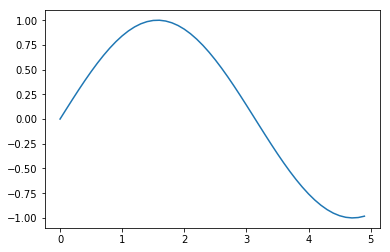

In [13]:
x = np.arange(0, 5, 0.1);
y = np.sin(x)
plt.plot(x, y)

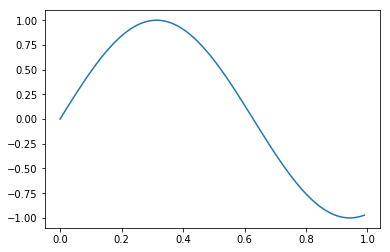

In [31]:
num_traj = 20
sigma_noise=0.03
x = np.arange(0,1,0.01)
A = np.array([.2, .2, .01, -.05])
X = np.vstack((np.sin(5*x), x**2, x, np.ones((1,len(x))))) # The polynomial terms are added to do Noise(Weiss noise)

plt.plot(x,X[0,:])


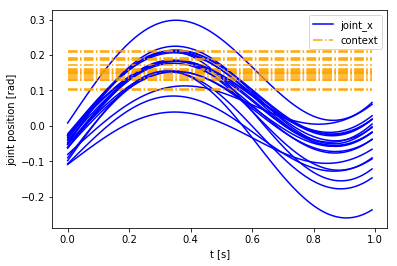

In [32]:
# we use one joint and one context
# feel free to use more joints or contexts
joints = ["joint_x", "context"]

Y = np.zeros((num_traj, len(x)))
samples = []
for traj in range(0, num_traj):
    sample = np.dot(A + sigma_noise * np.random.randn(1,4), X)[0]
    sample = np.vstack((sample, np.tile(sigma_noise * np.random.randn() + 0.15, len(x))))
    samples.append(sample)

samples = np.array(samples)
num_points=len(x)
plt.figure(figsize=(6, 4))

for i in range(0, num_traj):
    if i == 0:
        plt.plot(np.arange(0, len(samples[i, 0, :].T)) / num_points, samples[i, 0, :].T, color='blue', label='joint_x')
        plt.plot(np.arange(0, len(samples[i, 1, :].T)) / num_points, samples[i, 1, :].T, '-.', color='orange', label='context')
    else:
        plt.plot(np.arange(0, len(samples[i, 0, :].T)) / num_points, samples[i, 0, :].T, color='blue')
        plt.plot(np.arange(0, len(samples[i, 1, :].T)) / num_points, samples[i, 1, :].T, '-.', color='orange')
plt.xlabel('t [s]')
plt.ylabel('joint position [rad]')
plt.legend()

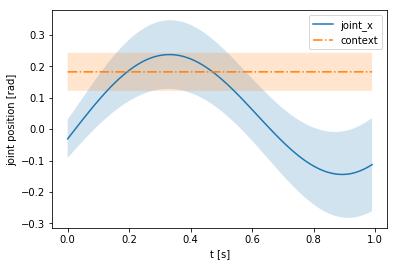

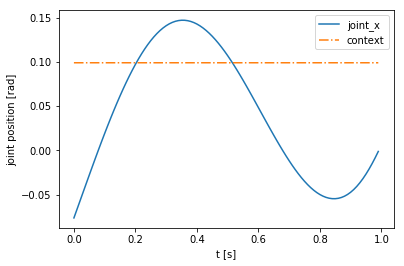

In [33]:
pmp = ProMPContext(joints, num_points=num_points)

# add demonstrations to ProMP
for demo_id in range(0, num_traj):
    pmp.add_demonstration(samples[demo_id, :, :].T)

# plot mean and standard deviation of demonstrations
pmp.plot_unconditioned_joints()

# condition on context=0.1
goal = np.zeros(2)
goal[1] = 0.1
pmp.clear_viapoints()
pmp.set_goal(goal, sigma=1e-6)
pmp.plot_conditioned_joints()


# SOME TEST TO CHECK PROMP CALCULATION

In [60]:
# TEST interp1d function
from scipy.interpolate import interp1d

demonstration = samples[0,0,:]
demonstration.shape

interpolate = interp1d(np.linspace(0, 1, len(demonstration)), demonstration, kind='cubic')

In [61]:
samples.shape

(20, 2, 100)

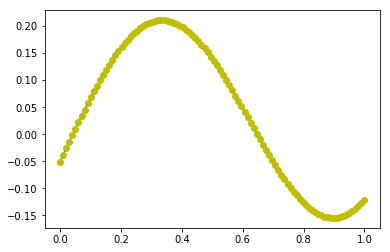

In [152]:
z = np.linspace(0, 1, 100)

stretched_demo = interpolate(z)

z0 = np.linspace(0, 1, len(demonstration))

plt.plot(z0,demonstration)
plt.plot(z,stretched_demo,'yo')


In [153]:
centros_0 = np.arange(0,20)/19
centros_1 = np.linspace(0,1,20)

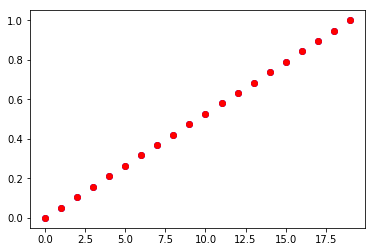

In [154]:
plt.plot(centros_0,'bo')
plt.plot(centros_1,'ro')

In [155]:
z = np.linspace(0,1,100)


v1 = np.tile(z,(20,1)).T

v2 = np.array(list(map(lambda x: x - centros_0,v1))).T**2

v2.shape

(20, 100)

In [156]:
sigma = 0.1
phi = np.exp(-0.5 * (v2/sigma**2))
phi.shape

phi /=np.sum(phi,axis=0) #Normalization

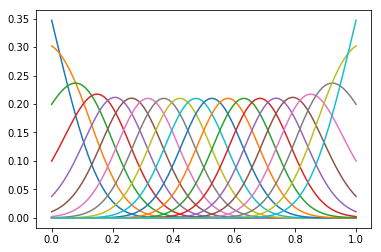

In [157]:
for i in range(20):
    plt.plot(z,phi[i,:])

In [158]:
aux = np.dot(phi,phi.T)

In [159]:
aux.shape

(20, 20)

# TWO WAYS REGRESSION

1. Using Scikit. linear model -> Obtain affine
2. Hardcoding the regression -> Obtain Linear

In [160]:
# Linear Regression : ax = b -> x = a^-1 * b
from sklearn import linear_model

print(stretched_demo.shape)

print(phi.shape)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(phi.T, stretched_demo)

regr.coef_.shape
W1 = regr.coef_

W1.shape

(100,)
(20, 100)


(20,)

In [161]:
# LINEAR REGRESSION BY HAND

aux = np.dot(phi,phi.T)
W2 = np.dot(np.linalg.inv(aux + np.eye(aux.shape[1])*1e-6), np.dot(phi, np.array(stretched_demo).T))


(100,)


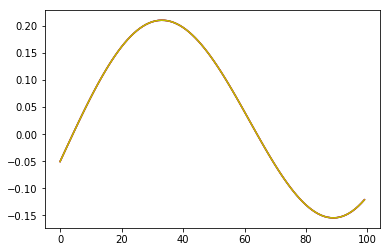

In [163]:
# TEST WHICH REGRESSION METHOD WORKS BETTER

y_test_1 = np.dot(phi.T,W1) + regr.intercept_
y_test_2 = np.dot(phi.T,W2)

print(y_test_1.shape)


plt.plot(stretched_demo,'b')

plt.plot(y_test_1,'r')
plt.plot(y_test_2,'y')